In [1]:
from pathlib import Path
from hbond_benchmark.model import Net as HNet
from hbond_benchmark.model import MolData
from molnet_geometric_lightning.model import Net as BaselineNet
from molnet_geometric_lightning.model import MolData as MolDataB
import torch
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
import numpy as np
import pandas as pd

/home/gltyk/miniconda3/envs/mgl/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
name = 'esol'
gnn = 'gin'
virtual_ = [True, False]


In [3]:
h_ckpts = {}
b_ckpts = {}
for virtual in virtual_:
    h_p = Path(f'/home/gltyk/hbond-benchmark/notebooks/models/{name}/{gnn}/{virtual}/lightning_logs')
    baseline_p = Path(f'/home/gltyk/molnet-geometric-lightning/notebooks/models/{name}/{gnn}/{virtual}/lightning_logs')
    h_ckpts[virtual] = list(h_p.glob('*/*/*.ckpt'))[0]
    b_ckpts[virtual] = list(baseline_p.glob('*/*/*.ckpt'))[0]
    

In [4]:
h_models = {}
b_models = {}
for virtual in virtual_:
    h_models[virtual] = HNet.load_from_checkpoint(
        h_ckpts[virtual],
        task_type='regression',
        h_bonds=True,
        num_tasks=1,
        evaluator=None,
    )
    b_models[virtual] = BaselineNet.load_from_checkpoint(
        b_ckpts[virtual],
        task_type='regression',
        num_tasks=1,
        evaluator=None,
    )
    b_models[virtual].eval();
    h_models[virtual].eval();


In [5]:
data_h = MolData(root='/home/gltyk/hbond-benchmark/notebooks/data', name=name, hydrogen_bonds=True)
data_base = MolDataB(root='/home/gltyk/molnet-geometric-lightning/data', name=name)
data_h.setup(stage='fit')
data_base.setup(stage='fit')

In [6]:
# edge type "HYDROGEN" is encoded as 5
mol_idx_with_hbonds = [int(i) for i in data_h.split_dict['test'] if (data_h.dataset[i].edge_attr == 5).any()]

In [7]:
def get_predictions(model, data_module):
    y_hats = []
    ys = []
    t = data_module.test_dataloader()
    for batch in tqdm(t, total=len(t)):    
        y_hat = model(batch).detach().numpy()
        y = batch.y.detach().numpy()
        y_hats.append(y_hat)
        ys.append(y)

    y_hats = np.concatenate(y_hats)
    ys = np.concatenate(ys)
    return ys, y_hats

In [8]:
h_predictions, b_predictions = {}, {}

for virtual in virtual_:
    y, y_hat_h = get_predictions(h_models[virtual], data_h)
    y, y_hat_b = get_predictions(b_models[virtual], data_base)
    h_predictions[virtual] = y_hat_h
    b_predictions[virtual] = y_hat_b


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


In [9]:
y_hat_h = {}
y_hat_b = {}

for virtual in virtual_:
    s = pd.Series(h_predictions[virtual].ravel(), index=data_h.split_dict['test'].numpy())    
    y_hat_h[virtual] = s


    s = pd.Series(b_predictions[virtual].ravel(), index=data_h.split_dict['test'].numpy())    
    y_hat_b[virtual] = s
    
y = pd.Series(y.ravel(), index=data_h.split_dict['test'].numpy())

In [10]:
result = []

def get_row(model_type, y, y_hat):
    return {
        'type': model_type,
        'r2 overall': r2_score(y, y_hat),
        'r2 has h_bond': r2_score(y[mol_idx_with_hbonds], y_hat[mol_idx_with_hbonds]),
        'r2 no h_bond': r2_score(y.drop(mol_idx_with_hbonds), y_hat.drop(mol_idx_with_hbonds)),
        'rmse overall': np.sqrt(mean_squared_error(y, y_hat)),
        'rmse has h_bond': np.sqrt(mean_squared_error(y[mol_idx_with_hbonds], y_hat[mol_idx_with_hbonds])),
        'rmse no h_bond': np.sqrt(mean_squared_error(y.drop(mol_idx_with_hbonds), y_hat.drop(mol_idx_with_hbonds))),
    }

for virtual in virtual_:
    result.append(get_row(f'hydrogen_{virtual}', y, y_hat_h[virtual]))
    result.append(get_row(f'baseline_{virtual}', y, y_hat_b[virtual]))


In [11]:
pd.DataFrame(result).groupby(['type']).agg('mean').T.round(3)  # for this model only

type,baseline_False,baseline_True,hydrogen_False,hydrogen_True
r2 overall,0.747,0.830,0.703,0.830
r2 has h_bond,0.747,0.822,0.846,0.785
r2 no h_bond,0.740,0.825,0.676,0.831
rmse overall,1.065,0.875,1.156,0.873
rmse has h_bond,0.960,0.806,0.749,0.886
rmse no h_bond,1.081,0.885,1.206,0.871


In [12]:
len(mol_idx_with_hbonds) / len(y)

0.13274336283185842

In [13]:
sh = data_h.dataset[mol_idx_with_hbonds]
sb = data_base.dataset[mol_idx_with_hbonds]

In [14]:
from torch_geometric.data import Batch
from rdkit import Chem

In [15]:
df = pd.DataFrame(
{
    'hydrogen_False': pd.Series(h_predictions[False].ravel(), index=data_h.split_dict['test'].numpy())[mol_idx_with_hbonds],
    'baseline_False': pd.Series(b_predictions[False].ravel(), index=data_base.split_dict['test'].numpy())[mol_idx_with_hbonds],
    
    'hydrogen_True': pd.Series(h_predictions[True].ravel(), index=data_h.split_dict['test'].numpy())[mol_idx_with_hbonds],
    'baseline_True': pd.Series(b_predictions[True].ravel(), index=data_base.split_dict['test'].numpy())[mol_idx_with_hbonds],

    
    'y': pd.Series(y.ravel(), index=data_base.split_dict['test'].numpy())[mol_idx_with_hbonds]
}
)

In [30]:
df[['baseline_True', 'hydrogen_False', 'y']].sort_values('y')

,baseline_True,hydrogen_False,y
482,-7.454962,-6.539331,-8.003
294,-4.023322,-3.541798,-4.576
449,-4.168364,-4.193625,-4.571
592,-2.970352,-2.881510,-4.160
588,-2.273321,-3.455056,-3.685
219,-4.080593,-3.984829,-3.571
428,-2.907598,-2.153650,-3.083
543,-2.736620,-3.050747,-2.850
515,-1.984379,-2.292837,-2.150
150,-0.762087,-1.438650,-1.950


In [17]:
pd.DataFrame({'baseline_True_err': abs(df.baseline_True - df.y), 'hydrogen_False_err': abs(df.hydrogen_False - df.y)})

,baseline_True_err,hydrogen_False_err
0,1.126954,1.233129
109,0.668302,0.097310
150,1.187913,0.511350
219,0.509593,0.413829
294,0.552679,1.034202
298,0.230548,0.005973
381,1.409169,0.304312
428,0.175402,0.929350
449,0.402637,0.377375
482,0.548038,1.463669


In [145]:
n = 592

In [146]:
df.loc[n]

hydrogen_False   -2.881510
baseline_False   -2.590127
hydrogen_True    -3.074745
baseline_True    -2.970352
y                -4.160000
Name: 592, dtype: float32

In [147]:
h_models[False](Batch.from_data_list([data_h.dataset[n]]));
b_models[True](Batch.from_data_list([data_base.dataset[n]]));


In [148]:
mol = Chem.MolFromSmiles(data_h.dataset[n].smiles)

In [149]:
from rdkit.Chem.Draw import SimilarityMaps

In [179]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 500,500
import matplotlib.pyplot as plt

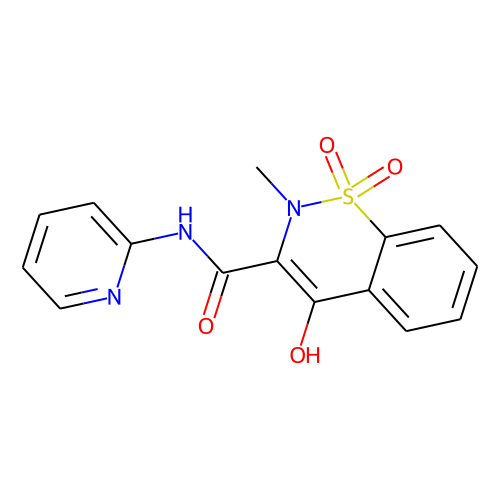

In [292]:
mol

In [293]:
Draw.MolToFile(mol, 'mol_esol.svg')

In [152]:
# these are the hbonds
data_h.dataset[n].edge_index.T[data_h.dataset[n].edge_attr[:, 0] == 5]

tensor([[ 4, 16],
        [16,  4]])

(0.0, 1.0, 0.0, 1.0)

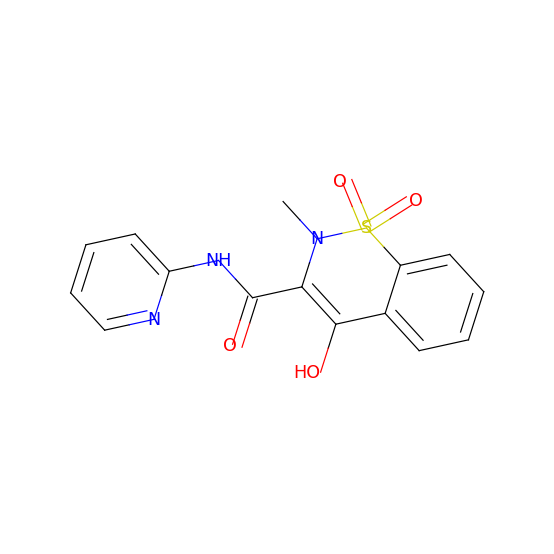

In [153]:
Draw.MolToMPL(mol, axes=False)
plt.axis('off')

# H vs Virt

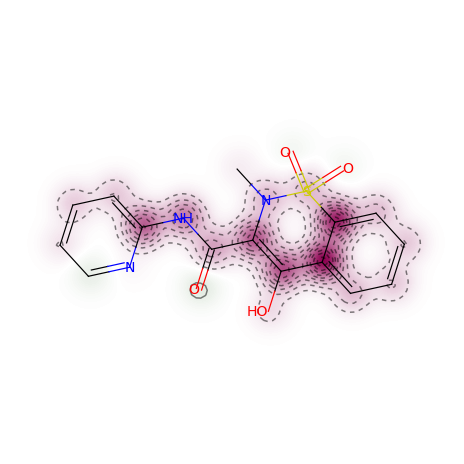

In [154]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, h_models[False].CAM()[0]);

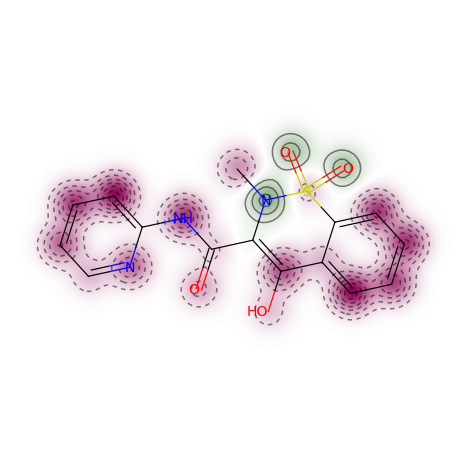

In [176]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, b_models[True].CAM()[0] + 14);

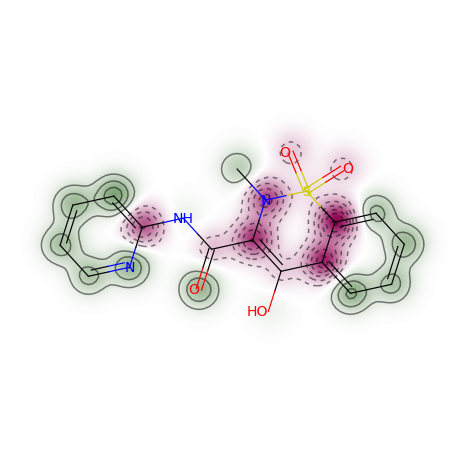

In [169]:
cam_h = h_models[False].CAM()[0]
cam_b = b_models[True].CAM()[0]
SimilarityMaps.GetSimilarityMapFromWeights(
    mol, 
    (cam_h - cam_h.mean()) / cam_h.std() - (cam_b - cam_b.mean()) / cam_b.std()
);

# H vs Baseline

In [170]:
b_models[False](Batch.from_data_list([data_base.dataset[n]]));

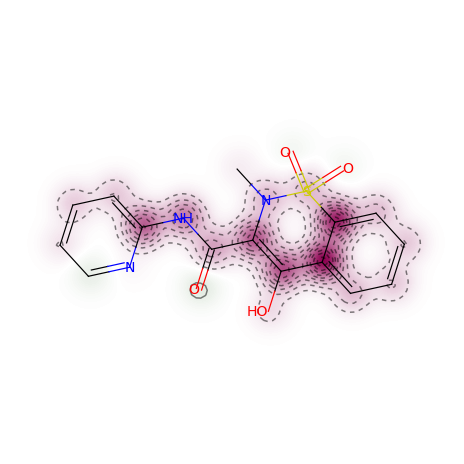

In [171]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, h_models[False].CAM()[0]);

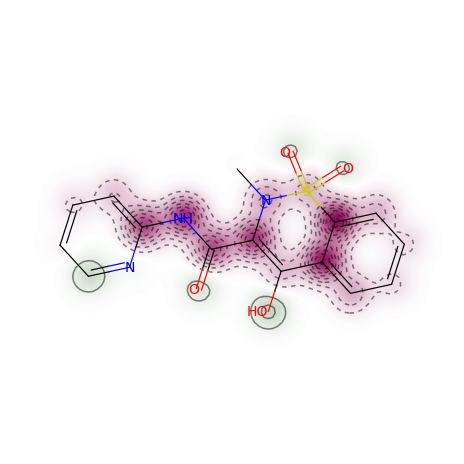

In [172]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, b_models[False].CAM()[0]);

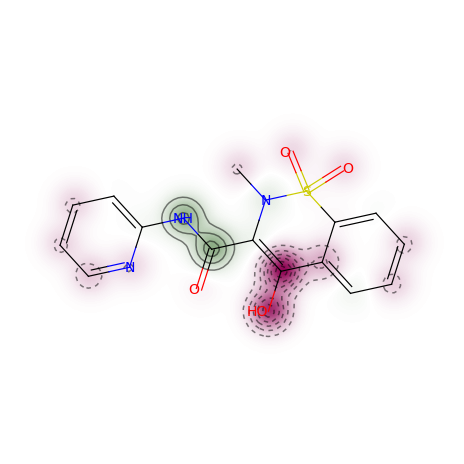

In [173]:
cam_h = h_models[False].CAM()[0]
cam_b = b_models[False].CAM()[0]
SimilarityMaps.GetSimilarityMapFromWeights(
    mol, 
    cam_h - cam_b,
);

In [183]:
def CAM(self, task=0):
    """Get the class attribution mapping for a task"""
    if task >= len(range(self.num_tasks)):
        raise ValueError(f'{task} must be between 0 and {self.num_tasks - 1}')
    task_index = task
    regression_weights = self.graph_pred_linear.weight[task_index].cpu().detach().numpy()
    GAP_like = self.graph_representation.cpu().detach().numpy()
    w = (regression_weights * GAP_like)
    w = w.reshape(1, -1)
    return w @ abs(self.node_representation.cpu().detach().numpy().T)

In [184]:
w = h_models[0].graph_pred_linear.weight.detach().numpy()[0] * h_models[0].graph_representation.detach().numpy()

In [21]:
b_models[0].graph_pred_linear.bias

Parameter containing:
tensor([-0.0717], requires_grad=True)

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Count'>

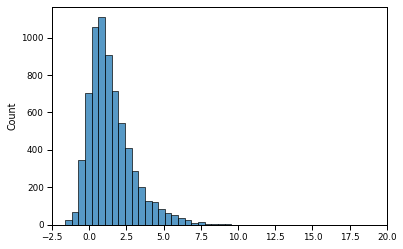

In [291]:
plt.xlim([-2.5, 20])
sns.histplot(h_models[False].node_representation.detach().numpy().ravel(), bins=25)

<AxesSubplot:ylabel='Count'>

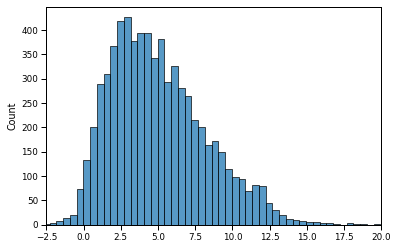

In [287]:
plt.xlim([-2.5, 20])
sns.histplot(b_models[True].node_representation.detach().numpy().ravel())

In [227]:
df_nbonds_h = pd.DataFrame(
    [(data_h.dataset[i].edge_attr == 5).sum().item() // 2 for i in data_h.split_dict['test']], index=data_h.split_dict['test'].numpy(), columns=['Num. H-bonds']
)
df_nbonds_v = df_nbonds_h.copy()

In [228]:
df_nbonds_h['Error'] = np.abs(y_hat_h[False] - y)
df_nbonds_h['Model Type'] = 'H-bond'
df_nbonds_v['Error'] = np.abs(y_hat_b[True] - y)
df_nbonds_v['Model Type'] = 'Virt. Node'

In [229]:
df_nbonds = pd.concat([df_nbonds_h, df_nbonds_v])

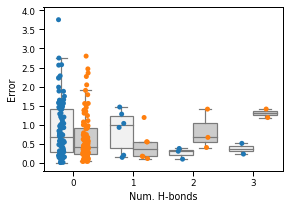

In [273]:
sns.set_context('paper')
plt.figure(figsize=(4, 3))
sns.stripplot(data=df_nbonds[df_nbonds['Num. H-bonds'] <= 3], x='Num. H-bonds', y='Error', hue='Model Type', dodge=True)
g = sns.boxplot(data=df_nbonds[df_nbonds['Num. H-bonds'] <= 3], x='Num. H-bonds', y='Error', hue='Model Type', color=".8", showfliers=False)
g.legend_.remove()
plt.tight_layout()
plt.ylim((None, 4.1))
plt.savefig('esol_nhbonds.svg')

In [269]:
plt.ylim

<function matplotlib.pyplot.ylim(*args, **kwargs)>